# *Proyecto de NLP*

---

 ## 📌 *objetivos:*

*El objetivo principal de este proyecto es evaluar y demostrar competencias prácticas en Procesamiento de Lenguaje Natural (NLP) mediante el desarrollo completo de un sistema de análisis de sentimiento. Para ello, se aplican técnicas modernas y realistas, alineadas con los desafíos que enfrentan actualmente las empresas en este ámbito.*

*En concreto, el proyecto consiste en desarrollar un modelo de clasificación binaria capaz de predecir si una reseña sobre un producto gourmet expresa una opinión positiva (score = 1) o negativa (score = 0), basándose exclusivamente en el contenido textual de la reseña.*

*A lo largo del proyecto, se han abordado todas las fases fundamentales de un pipeline NLP clásico, estructuradas en 3 etapas clave:*

1. *1era Parte: Analisis exploratorio*.
2. *2da Parte: Preprocesado de Texto*.
3. *3era Parte: Entrenamiento, evaluación, reporte de métricas y conclusiones*.


---


### 🔍 *1era Parte: Analisis exploratorio*
***Descarga y exploración del corpus***

*El objetivo es comprender la estructura y características del conjunto de datos antes de aplicar cualquier técnica de modelado.*

*El análisis incluye los siguientes elementos clave:*
- ***Cardinalidad del vocabulario:*** *cantidad total de palabras únicas presentes en las reseñas.*
- ***Distribución de reviews por número de estrellas:*** *análisis de la frecuencia de valoraciones (ratings) asignadas por los usuarios.*
- ***Número de reseñas positivas y negativas***: *clasificación binaria basada en el score para identificar el equilibrio de clases.*
- ***N-grams más frecuentes:*** *identificación de combinaciones de palabras comunes que aportan contexto al sentimiento.*
- ***Nubes de palabras (Word Clouds)***: *visualización de los términos más relevantes y frecuentes.*
- ***Visualización en 2D de embeddings de palabras***: *representación bidimensional de algunos word embeddings obtenidos con spaCy y ajustados con adjustText para analizar relaciones semánticas entre palabras.*
- ***Conclusiones del análisis:*** *interpretación de hallazgos relevantes que guiarán las etapas siguientes del preprocesado y modelado.*

---



In [ ]:
# imports
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pr
import nltk
import spacy

# modelos y metricas
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


In [2]:
file_path = r"C:\Users\oridi\Desktop\Programacion\NLP\NLP-main\Project\MyProject\Grocery_and_Gourmet_Food_5.json"

data = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line:
            obj = json.loads(line)
            data.append(obj)

print(f"Loaded {len(data)} JSON objects")
# data es una lista con todos los objetos JSON


Loaded 151254 JSON objects


In [3]:
# Crear DataFrame para facilitar el análisis
df = pd.DataFrame(data)

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013"
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3.0,"3.5 stars, sadly not as wonderful as I had hoped",1400457600,"05 19, 2014"
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013"
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]","I had never had it before, was curious to see ...",5.0,Unexpected flavor meld,1369008000,"05 20, 2013"
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",I've been looking forward to trying these afte...,4.0,"Not a very strong tea flavor, but still yummy ...",1369526400,"05 26, 2013"


In [5]:
df.isna().value_counts()

reviewerID  asin   reviewerName  helpful  reviewText  overall  summary  unixReviewTime  reviewTime
False       False  False         False    False       False    False    False           False         149761
                   True          False    False       False    False    False           False           1493
Name: count, dtype: int64

In [6]:
print(df.shape)
print(list(df.columns.sort_values()))

(151254, 9)
['asin', 'helpful', 'overall', 'reviewText', 'reviewTime', 'reviewerID', 'reviewerName', 'summary', 'unixReviewTime']


> ***Conociendo nuestros datos***:

| Columna          | Qué representa                                                                                      |
|------------------|---------------------------------------------------------------------------------------------------|
| ***asin***         | *Amazon Standard Identification Number*: *código único del producto.*                                |
| ***helpful***      | *Votos de utilidad de la review, generalmente un par `[n_helpful, n_total]` indicando cuántos usuarios encontraron útil la review.* |
| ***overall***      | *Calificación o nota que el usuario dio al producto, de 1 a 5 estrellas.*                 |
| ***reviewText***   | *Texto completo de la review escrita por el usuario.*                                               |
| ***reviewTime***   | *Fecha de la review.*                               |
| ***reviewerID***   | *Identificador único del usuario que escribió la review.*                                          |
| ***reviewerName*** | *Nombre del usuario que escribió la review.*                                  |
| ***summary***      | *Resumen breve o título de la review.*                      |
| ***unixReviewTime*** | *Fecha de la review en formato timestamp Unix (segundos desde 1970).*                            |


In [8]:
from collections import Counter
import re


def tokenize(text):
    # Minusculas y solo palabras con letras
    return re.findall(r'\b\w+\b', text.lower())

# Tokenizamos todas las reviews
all_tokens = []
df['reviewText'].dropna(inplace=True)
for review in df['reviewText']:
    all_tokens.extend(tokenize(review))

vocab = set(all_tokens)
print(f"Cardinalidad del vocabulario: {len(vocab)} palabras únicas")


Cardinalidad del vocabulario: 78357 palabras únicas


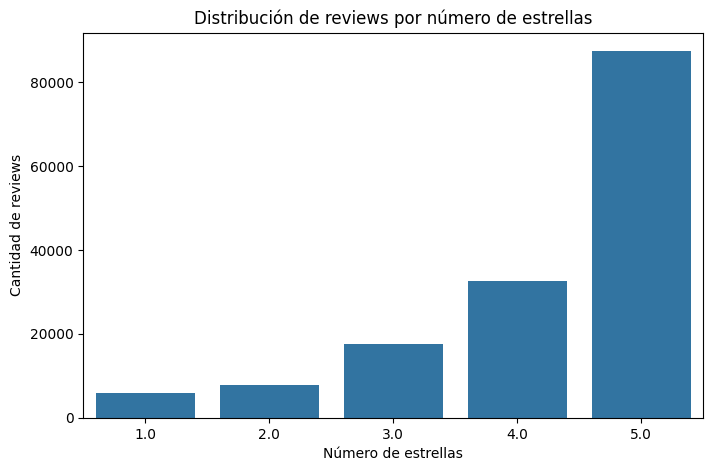

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(x='overall', data=df)
plt.title("Distribución de reviews por número de estrellas")
plt.xlabel("Número de estrellas")
plt.ylabel("Cantidad de reviews")
plt.show()


In [10]:
percentages_stars = df['overall'].value_counts(normalize=True) * 100

for star, pct in percentages_stars.items():
    print(f"{star} stars: {pct:.2f}%")


5.0 stars: 57.81%
4.0 stars: 21.55%
3.0 stars: 11.58%
2.0 stars: 5.23%
1.0 stars: 3.82%


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Unigramas
vectorizer_uni = CountVectorizer(stop_words='english', ngram_range=(1,1))
X_uni = vectorizer_uni.fit_transform(df['reviewText'].dropna())

sum_words_uni = X_uni.sum(axis=0)
words_freq_uni = [(word, sum_words_uni[0, idx]) for word, idx in vectorizer_uni.vocabulary_.items()]
words_freq_uni = sorted(words_freq_uni, key=lambda x: x[1], reverse=True)

print("Top 10 unigramas más frecuentes:")
print(words_freq_uni[:10])

# Bigramas
vectorizer_bi = CountVectorizer(stop_words='english', ngram_range=(2,2))
X_bi = vectorizer_bi.fit_transform(df['reviewText'].dropna())

sum_words_bi = X_bi.sum(axis=0)
words_freq_bi = [(word, sum_words_bi[0, idx]) for word, idx in vectorizer_bi.vocabulary_.items()]
words_freq_bi = sorted(words_freq_bi, key=lambda x: x[1], reverse=True)

print("Top 10 bigramas más frecuentes:")
print(words_freq_bi[:10])


Top 10 unigramas más frecuentes:
[('like', np.int64(95347)), ('good', np.int64(74152)), ('taste', np.int64(72097)), ('flavor', np.int64(62800)), ('just', np.int64(57155)), ('coffee', np.int64(55394)), ('great', np.int64(46429)), ('tea', np.int64(43990)), ('product', np.int64(37743)), ('really', np.int64(36039))]
Top 10 bigramas más frecuentes:
[('gluten free', np.int64(8078)), ('taste like', np.int64(5774)), ('peanut butter', np.int64(5592)), ('ve tried', np.int64(4655)), ('green tea', np.int64(4402)), ('dark chocolate', np.int64(4184)), ('tastes like', np.int64(4142)), ('cup coffee', np.int64(3878)), ('really good', np.int64(3728)), ('just right', np.int64(3669))]


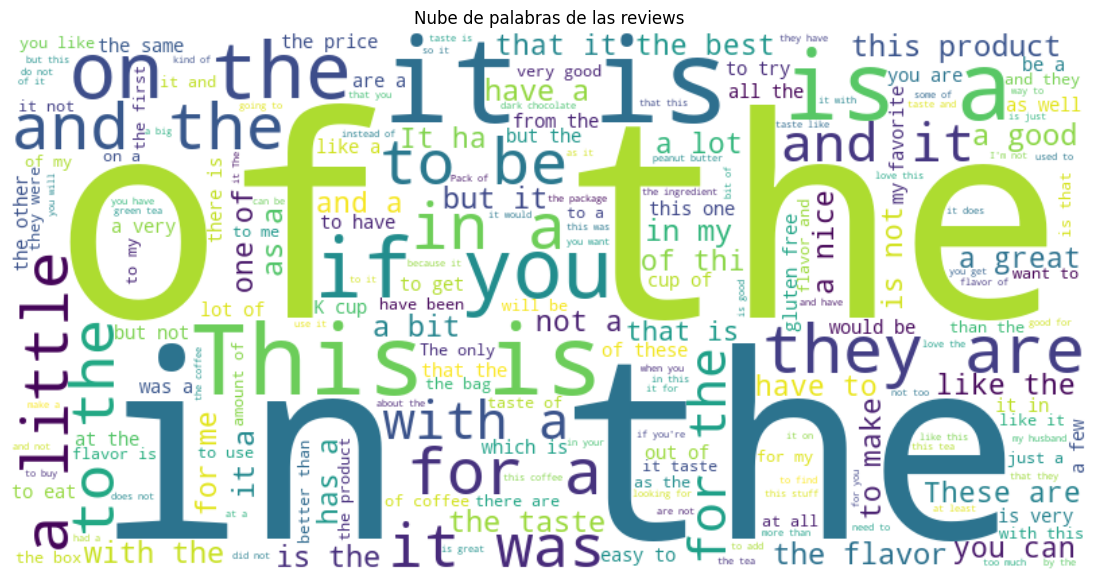

In [12]:
text = " ".join(df['reviewText'].dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras de las reviews")
plt.show()


> ***Podemos observar que las palabras con mayor peso son Stop-Words***
---


19 [-0.23839458  0.15668989]
20 [-0.3122016  -0.67740391]
27 [-0.97019681  0.23663071]
32 [-0.42174502 -0.81104767]
14 [ 0.16097746 -0.84604286]
18 [-0.03575224 -0.48648369]
36 [-0.4386258  -0.71041637]
42 [-0.23277184  0.87683577]


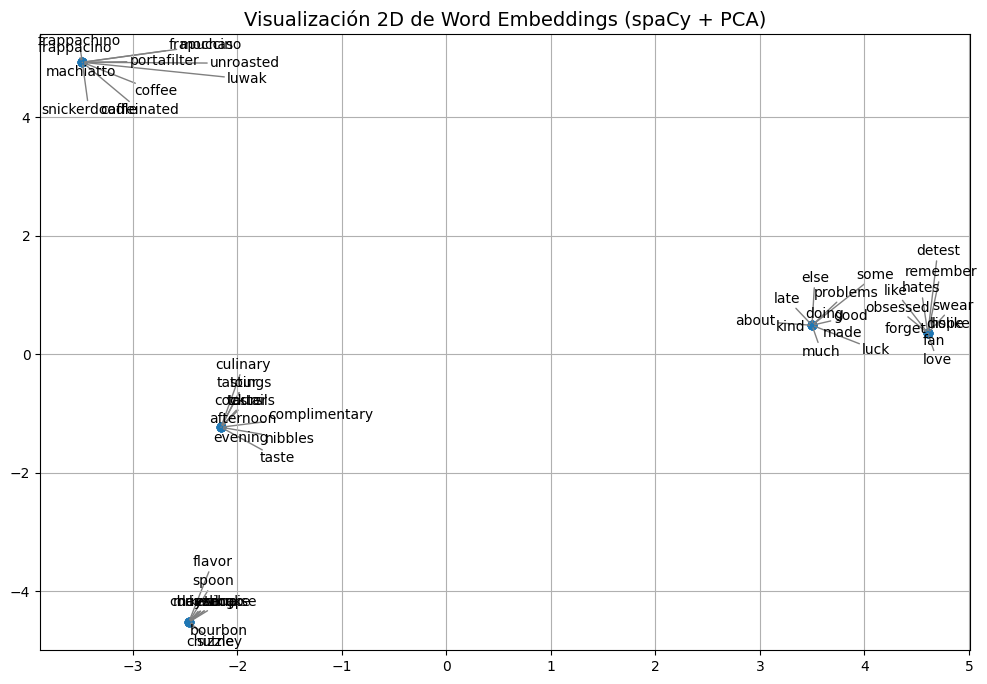

In [13]:

from sklearn.decomposition import PCA
from adjustText import adjust_text

# Cargar modelo spaCy con vectores
nlp = spacy.load("en_core_web_md")
df_text = df[['reviewText']].dropna()

# Procesar texto: lematizar, eliminar stopwords y puntuación
all_tokens = []
for doc in nlp.pipe(df_text['reviewText'], batch_size=10):
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    all_tokens.extend(tokens)

# Contar frecuencia de palabras
word_freq = Counter(all_tokens)

# Seleccionar top 5 palabras más frecuentes con vectores
target_words = [w for w, _ in word_freq.most_common(5) if nlp.vocab[w].has_vector]

# Función para obtener top 10 similares a una palabra
def get_similar_words(word, topn=10):
    query = nlp.vocab[word]
    if not query.has_vector:
        return []
    similarities = []
    for lex in nlp.vocab:
        if lex.has_vector and lex.is_lower and lex.is_alpha:
            similarity = query.similarity(lex)
            similarities.append((lex.text, similarity))
    return sorted(similarities, key=lambda x: -x[1])[1:topn+1]

# Construir lista de vectores y etiquetas
words_to_plot = []
labels = []

for word in target_words:
    labels.append(word)
    words_to_plot.append(nlp.vocab[word].vector)
    similars = get_similar_words(word)
    for sim_word, _ in similars:
        if nlp.vocab[sim_word].has_vector:
            labels.append(sim_word)
            words_to_plot.append(nlp.vocab[sim_word].vector)

# Reducir dimensionalidad a 2D con PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(words_to_plot)

# Graficar 
plt.figure(figsize=(12, 8))
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.6)

texts = []
for i, label in enumerate(labels):
    texts.append(plt.text(coords[i, 0], coords[i, 1], label, fontsize=10))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.title("Visualización 2D de Word Embeddings (spaCy + PCA)", fontsize=14)
plt.grid(True)
plt.show()


📌 ***Justificación del uso de spaCy en lugar de gensim para trabajar con Word Embeddings***

*Debido a problemas de compatibilidad y conflictos de versiones al instalar la librería gensim en mi entorno local (relacionados principalmente con la dependencia de compiladores numpy), he optado por utilizar una alternativa robusta y moderna como es spaCy.*

*El modelo en_core_web_md de spaCy incluye vectores preentrenados de palabras que permiten trabajar con embeddings sin necesidad de entrenamiento manual. Esto no solo evita los errores de instalación, sino que también:*

- *Ofrece vectores semánticos entrenados sobre corpus grandes.*
- *Permite calcular similitudes entre palabras de forma directa.*
- *Es eficiente y está optimizado.*
- *Reduce la carga computacional.*

*En resumen, el uso de spaCy ha permitido mantener la funcionalidad del análisis semántico mediante embeddings, asegurando la compatibilidad con el entorno local y garantizando estabilidad en la ejecución del código.*

In [14]:
print("Palabras más frecuentes (post-embedding):")
for word, freq in word_freq.most_common(10):
    print(f"{word}: {freq}")

Palabras más frecuentes (post-embedding):
like: 105235
taste: 100705
good: 88923
flavor: 83383
coffee: 58283
try: 49227
tea: 48650
product: 47258
great: 46542
love: 41494



---
### 💡 *Conclusiones de la exploración:*

- ***¿Cuántas palabras únicas hay? ¿Es un vocabulario amplio o limitado?*** : *Hay un 52% de palabras únicas sobre el total, lo que es bastante alto y significa que hay mucha variedad léxica en el texto.*
> *concluimos que el dataset tiene buena diversidad léxica.*

- ***¿La distribución de estrellas está balanceada o no?***: *Las clases no están balanceadas: La mayoría (casi 79%) de las reviews tienen una calificación alta (4 o 5 estrellas), concentrándose en dos clases principales. Las clases bajas (1 y 2 estrellas) suman menos del 10% del total, lo que representa una minoría pequeña de ejemplos y  La clase de 3 estrellas, considerada neutral, también es mucho menor comparada con las positivas.*
    - ***Consecuencias practicas:*** *Los modelos entrenados con esta distribución tenderán a sesgarse hacia las clases mayoritarias (4 y 5 estrellas), prediciendo principalmente resultados positivos. Las clases minoritarias (reviews negativas) tienen menos ejemplos para aprender sus patrones, lo que puede llevar a un rendimiento bajo en la detección de reviews negativas. Por ello, es recomendable aplicar técnicas de balanceo (undersampling, oversampling, generación sintética) o ajustar métricas de evaluación para manejar este desbalance.*

- ****¿Hay más reviews positivas que negativas?***: *Si*.

- ***¿Qué palabras o frases aparecen más? ¿Qué indica esto?***: *Lo que indican estas palabras frecuentes es el tono dominante en las reviews, observamos que el corpus tiene una tendencia positiva, siendo "like" la palabra mas repetida*

---


 ##  ⚙️ *2da Parte: Preprocesado de Texto*


***Flujo de trabajo***:

1. *Reducir el dataset, filtrando reviews relevantes.*
2. *Transformar a clase binaria generando una nueva columna.* 
3. *Dividir el dataset en train y test (manteniendo proporciones con stratify) y balanceando clases.*
4. *Preprocesar el texto por separado en train y test, para evitar fugas de información.*
5. *Funcion que concentra todo el preprocesado*

In [15]:
# Preprocesado
from stop_words import get_stop_words 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [33]:
# Cargar JSON línea por línea por seguridad a que no se carguen mal al pasarlos al DataFrame
# Lo volvemos a cargar por seguridad, ya que hemos utilizado embeddings anteriormente
file_path = r"C:\Users\oridi\Desktop\Programacion\NLP\NLP-main\Project\MyProject\Grocery_and_Gourmet_Food_5.json"

reviews_text = []
reviews_sentiment = []

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        review = json.loads(line)
        text = review.get('reviewText')
        sentiment = review.get('overall')
        if text and sentiment:  # asegurarse de que no esté vacío
            reviews_text.append(text)
            reviews_sentiment.append(sentiment)

# Crear DataFrame limpio
df = pd.DataFrame({
    'review': reviews_text,
    'sentiment': reviews_sentiment
})

df.reset_index(drop=True, inplace=True)

In [17]:
# Etiquetar: 1 = negativo, 0 = positivo
def label_sentiment(score):
    return 1 if float(score) < 4 else 0

df['sentiment_label'] = df['sentiment'].apply(label_sentiment)

In [18]:
df.head()

,review,sentiment,sentiment_label
0,Just another flavor of Kit Kat but the taste i...,4.0,0
1,I bought this on impulse and it comes from Jap...,3.0,1
2,Really good. Great gift for any fan of green t...,4.0,0
3,"I had never had it before, was curious to see ...",5.0,0
4,I've been looking forward to trying these afte...,4.0,0


sentiment_label
0    120029
1     31203
Name: count, dtype: int64


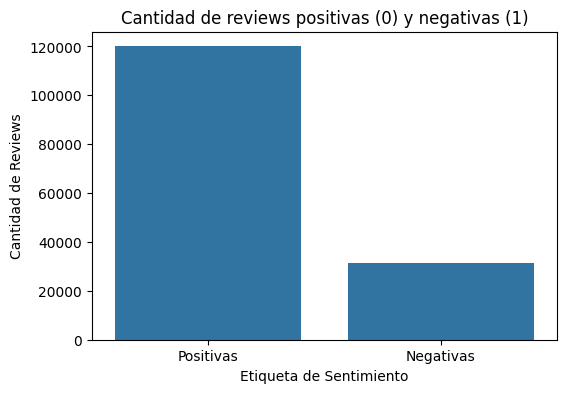

In [19]:
print(df['sentiment_label'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment_label', data=df, order=[0, 1])
plt.title("Cantidad de reviews positivas (0) y negativas (1)")
plt.xlabel("Etiqueta de Sentimiento")
plt.ylabel("Cantidad de Reviews")
plt.xticks(ticks=[0, 1], labels=['Positivas', 'Negativas'])
plt.show()


In [20]:
sentences = df['review'].values
labels = df['sentiment_label'].values
sentences[0]

'Just another flavor of Kit Kat but the taste is unique and a bit different.  The only thing that is bothersome is the price.  I thought it was a bit expensive....'

In [21]:
# SPLIT para evitar DataLeakage manteniendo proporciones de clases 
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['sentiment_label'],
    test_size=0.2,
    stratify=df['sentiment_label'],
    random_state=42
)

print("Train instances:", len(X_train))
print("Train labels:", len(y_train))
print("Example:", y_train.iloc[5])

print("Test instances:", len(X_test))
print("Test labels:", len(y_test))
print("Example:", y_test.iloc[2])

Train instances: 120985
Train labels: 120985
Example: 0
Test instances: 30247
Test labels: 30247
Example: 1


In [22]:
print("Distribución en train:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nDistribución en test:")
print(pd.Series(y_test).value_counts(normalize=True))

Distribución en train:
sentiment_label
0    0.793677
1    0.206323
Name: proportion, dtype: float64

Distribución en test:
sentiment_label
0    0.793665
1    0.206335
Name: proportion, dtype: float64


In [23]:
from imblearn.over_sampling import RandomOverSampler

# Convertimos X_train a DataFrame necesario para el RandomOverSampler
X_train_df = X_train.to_frame()

# Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_df, y_train)

# Comprobamos nueva distribución
print("\nDistribución después del oversampling:")
print(y_resampled.value_counts())

# convertir de nuevo a Series para mantener formato
X_train_balanced = X_resampled['review']
y_train_balanced = y_resampled



Distribución después del oversampling:
sentiment_label
0    96023
1    96023
Name: count, dtype: int64


In [24]:
# Tras oversampling asegura que es una Series
X_train_balanced = X_resampled['review']
y_train_balanced = pd.Series(y_resampled)  

> - *`X_train_balanced`: Serie de textos -> aplicar preprocess_text*
> - *`y_train_balanced`: Serie de etiquetas -> uso directo*

📌 ***Justificación del uso de `RandomOverSampler`***:

*En nuestro problema de análisis de sentimiento, observamos un fuerte desbalance entre clases:*
- *Positivas (label=0): ~79%*
- *Negativas (label=1): ~21%*

*`RandomOverSampler` es una técnica simple, rápida y efectiva que duplica aleatoriamente ejemplos de la clase minoritaria hasta igualar el tamaño de la clase mayoritaria y no elimina datos de la clase mayoritaria.*

📌 ***Justificación del uso de `Series`:***
1. *Acceso a métodos útiles.*
2. *Mejor integración con visualización y análisis.*
3. *Permite aplicar funciones vectorizadas con .apply().*

---

In [25]:
# Descargar recursos

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oridi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\oridi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oridi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oridi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
from nltk.tokenize import sent_tokenize
text = "Hello! this is a test."
print(sent_tokenize(text))

['Hello!', 'this is a test.']


In [27]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_punctuation(text):
    # Elimina todo lo que no sea letra o espacio
    return re.sub(r'[^a-zA-Z\s]', '', text)

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

def preprocess_text(text):
    # 1. Texto a minúsculas
    text = text.lower()
    # 2. Eliminar puntuación
    text = remove_punctuation(text)
    # 3. Tokenizar
    tokens = nltk.word_tokenize(text)
    # 4. Eliminar stopwords
    tokens = remove_stopwords(tokens)
    # 5. Lematizar
    tokens = lemmatize_tokens(tokens)
    # 6. Unir tokens en string limpio
    return " ".join(tokens)



---

> 📌 *El objetivo de esta etapa es preparar el texto de las reviews para que el modelo de análisis de sentimiento pueda aprender de manera efectiva. El texto crudo suele contener ruido y variabilidad que dificultan el aprendizaje, por lo que es necesario transformarlo en un formato más limpio y homogéneo.*

*Toda esta etapa se implementa en una función principal de Python, que puede llamar a funciones auxiliares para tareas específicas*

 ***Pasos del Preprocesado y Justificación:***
1. ***Conversión a minúsculas (lowercasing)***: *Qué se hace: Convertir todo el texto a letras minúsculas.*
    - ***¿Por qué?*** :*Reduce la variabilidad entre palabras que solo difieren en mayúsculas (p. ej. "Good" y "good" se consideran la misma palabra).*
    - ***Beneficio***: *Disminuye el tamaño del vocabulario y mejora la consistencia.*
2. ***Eliminación de signos de puntuación***: *Quitar caracteres que no sean letras o espacios (puntos, comas, signos de interrogación, etc.).*
    - ***¿Por qué?***:*La puntuación rara vez aporta información relevante para análisis de sentimiento en esta etapa básica, y puede aumentar el ruido.*
    - **Beneficio***: *Simplifica el texto y mejora la tokenización.*
3. ***Tokenización***: *Dividir el texto en palabras o tokens individuales.*
    - ***¿Por qué?***: *Los modelos de NLP trabajan con tokens (palabras o subunidades), no con texto plano*.
    - ***Beneficio***: *Permite procesar y analizar cada unidad semántica por separado.*
4. ***Eliminación de stopwords*** :*Remover palabras muy frecuentes y poco informativas (como "the", "is", "and").*
    - ***¿Por qué?*** *Estas palabras aportan poco significado y pueden interferir con la identificación de patrones relevantes.*
    - ***Beneficio***: *Reduce ruido y dimensionalidad sin perder información importante.*
5. ***Lematización (o stemming)***: *Transformar cada palabra a su forma base o raíz (p. ej. "running" → "run").*
      - ***¿Por qué?***: *Agrupa diferentes formas de una misma palabra para que el modelo generalice mejor.*
      - ***Beneficio***: *Reduce la variabilidad léxica y mejora la calidad de los vectores de texto.*
6. ***Reconstrucción del texto limpio***: *Unir los tokens procesados de nuevo en un string.*
      - **¿Por qué?*** Algunos modelos o vectorizadores esperan texto plano.*
      - ***Beneficio:*** Permite usar el texto limpio en etapas posteriores como vectorización o embedding.*


---

## 🧠 *3era Parte: Entrenamiento, evaluación, reporte de métricas y conclusiones*

> 📌 ***Objetivo:*** *Identificar el modelo más robusto y adecuado para el tipo de texto y distribución de clases del dataset.*

 ***Enfoque de clasificación binaria supervisada.***
1. ***Preprocesamiento y Vectorización del Texto***: *Transformar los textos en una representación numérica que los modelos puedan interpretar.*   
2. ***Entrenamiento de Modelos:*** *Ajustar diferentes modelos de clasificación al conjunto de entrenamiento vectorizado.*   
3.  ***Evaluación y Comparación de Resultados***: *Comparar el rendimiento de todos los modelos y decidir cuál se adapta mejor a la tarea.*   
4. ***Métricas evaluadas:***
   - **Accuracy (Exactitud)***: Mide el porcentaje global de aciertos. Sensible a clases desbalanceadas( hemos balanceado).*
   -  **Precision (Precisión)***: De todas las veces que el modelo predijo "Positivo" (1), cuántas veces fue correcto. **Alta precision = pocas falsas alarmas.***
   -   **Recall (Sensibilidad o Exhaustividad)***: De todos los casos realmente de clase 1 (Positivo), cuántos detectó el modelo. **Alta recall = pocos falsos negativos.***
   -  ***F1-Score***: *Equilibrio entre precisión y recall.Útil cuando hay desbalance de clases( no es nuestro caso)*
5. ***Visualización***:*Se genera un gráfico comparativo (barplot) con todas las métricas y modelos, para interpretar fácilmente qué combinación de modelo y vectorización ofrece el mejor rendimiento.*

 ---



In [28]:
# Preprocesado solo a TRAIN!
X_train_processed = X_train_balanced.apply(preprocess_text)

In [29]:
# 1. Vectorización TF-IDF y CountVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
count_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1,2))

# TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)
# Count
X_count = count_vectorizer.fit_transform(X_train_processed)

# 2. Split para evaluación
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y_train_balanced, test_size=0.2, random_state=42, stratify=y_train_balanced)
X_train_count, X_test_count, _, _ = train_test_split(X_count, y_train_balanced, test_size=0.2, random_state=42, stratify=y_train_balanced)

###  📌 *¿Por qué hay que vectorizar el texto?* 

*Los algoritmos de Machine Learning trabajan con valores numéricos, no con texto "crudo". Para que un modelo pueda aprender a partir de los datos, es necesario convertir las palabras en representaciones numéricas que conserven el significado o la estructura del texto.*

***Comparación de técnicas de vectorización:***
 - `CountVectorizer:`*Es una implementación concreta de la técnica Bag of Words (BoW) que representa los textos como conteos de palabras, es decir, cuenta cuántas veces aparece cada palabra del vocabulario en cada documento: crea una matriz en la que cada fila representa un documento y cada columna representa una palabra del vocabulario. El valor en cada celda es el número de veces que esa palabra aparece en el documento*
 - `TF-IDF` *(Term Frequency - Inverse Document Frequency): Pondera la frecuencia de una palabra en un documento VS su frecuencia global en el corpus, resaltando las palabras más informativas.Ignora el contexto*

In [30]:
# Modelos
models = {
    "KNN (TF-IDF)": KNeighborsClassifier(n_neighbors=5),
    "Random Forest (TF-IDF)": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVC (TF-IDF)": LinearSVC(max_iter=1000, random_state=42),
    "LogisticRegression (TF-IDF)":LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "LogisticRegression (Count)" :LogisticRegression(max_iter=200, random_state=42),
    "KNN (Count)": KNeighborsClassifier(n_neighbors=5),
    "Random Forest (Count)": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVC (Count)": LinearSVC(max_iter=1000, random_state=42)
}

# Entrenamiento y evaluación
for name, model in models.items():
    print(f"\n Modelo: {name}")
    
    if 'TF-IDF' in name:
        model.fit(X_train_tfidf, y_train)
        y_pred = model.predict(X_test_tfidf)
    else:
        model.fit(X_train_count, y_train)
        y_pred = model.predict(X_test_count)
    
    print(classification_report(y_test, y_pred, digits=4))



 Modelo: KNN (TF-IDF)
              precision    recall  f1-score   support

           0     0.8636    0.2551    0.3939     19205
           1     0.5630    0.9597    0.7097     19205

    accuracy                         0.6074     38410
   macro avg     0.7133    0.6074    0.5518     38410
weighted avg     0.7133    0.6074    0.5518     38410


 Modelo: Random Forest (TF-IDF)
              precision    recall  f1-score   support

           0     0.9804    0.9374    0.9584     19205
           1     0.9400    0.9813    0.9602     19205

    accuracy                         0.9593     38410
   macro avg     0.9602    0.9593    0.9593     38410
weighted avg     0.9602    0.9593    0.9593     38410


 Modelo: Linear SVC (TF-IDF)
              precision    recall  f1-score   support

           0     0.8548    0.8436    0.8492     19205
           1     0.8457    0.8567    0.8511     19205

    accuracy                         0.8502     38410
   macro avg     0.8502    0.8502    0.850

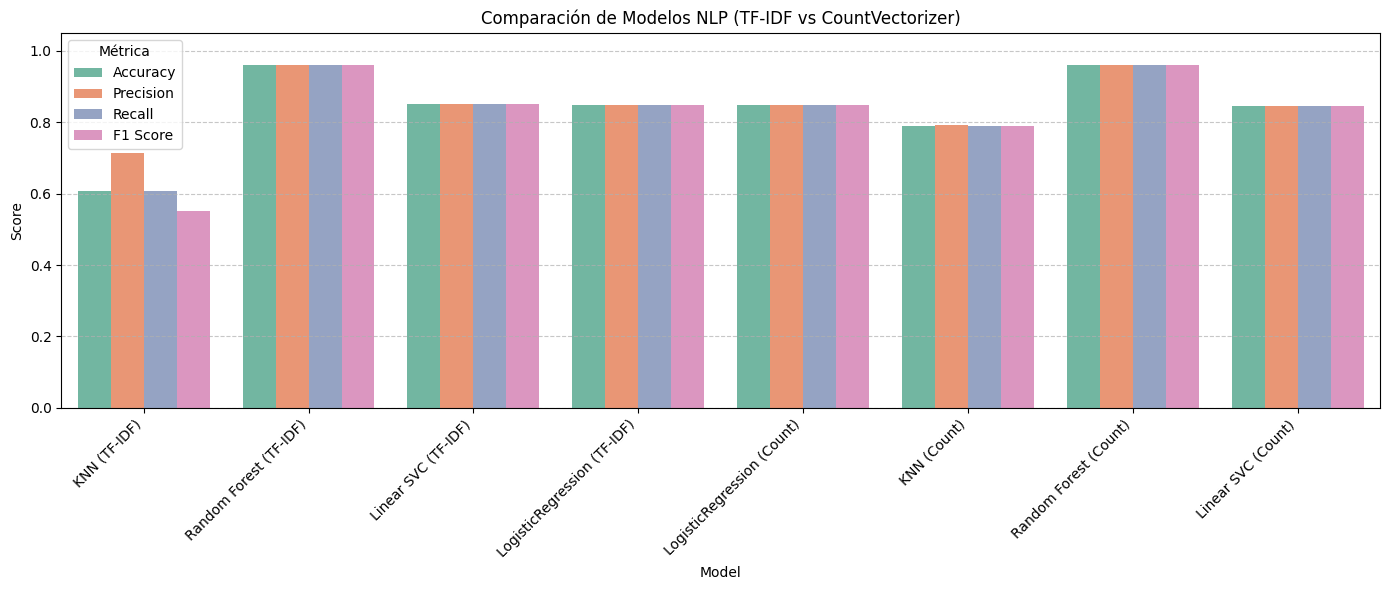

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Diccionario para guardar resultados
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Repetimos evaluación pero guardando métricas
for name, model in models.items():
    if 'TF-IDF' in name:
        y_pred = model.predict(X_test_tfidf)
    else:
        y_pred = model.predict(X_test_count)
    
    results["Model"].append(name)
    results["Accuracy"].append(accuracy_score(y_test, y_pred))
    results["Precision"].append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    results["Recall"].append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
    results["F1 Score"].append(f1_score(y_test, y_pred, average='weighted', zero_division=0))

# Convertimos a DataFrame
results_df = pd.DataFrame(results)

results_melted = pd.melt(results_df, id_vars="Model", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=results_melted, x="Model", y="Score", hue="Metric", palette="Set2")

plt.title("Comparación de Modelos NLP (TF-IDF vs CountVectorizer)")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.tight_layout()
plt.legend(title="Métrica")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()



---

#  💡 *Conclusiones*

### ***Modelos usados y cómo funcionan:***
1. ***`K-Nearest Neighbors (KNN)`***: *KNN es un algoritmo basado en la distancia. Para clasificar un nuevo texto, compara su representación vectorial con las de los textos del entrenamiento y asigna la clase más común entre sus k vecinos más cercanos.*
   - *Rinde bien en datasets pequeños. Lento con muchos datos (costoso al predecir) y sensible a la escala y al ruido.*
   - 
  
2. ***`Random Forest`:*** *Es un ensamble de árboles de decisión. Cada árbol aprende reglas distintas del dataset (mediante muestreo y selección aleatoria de variables). Luego, votan en conjunto para predecir la clase.*
   - *Robusto contra overfitting, acepta relaciones no lineales y datos ruidosos pero, es difícil de interpretar  costoso en recursos para datasets muy grandes.*


3. ***`LinearSVC` (Support Vector Machine lineal)***: *Encuentra un hiperplano óptimo que separa las clases con el mayor margen posible. En su versión lineal, esto equivale a ajustar una frontera lineal entre los vectores de texto.*
   - *Es muy eficaz en espacios de alta dimensión (como TF-IDF), generaliza bien incluso con pocos datos pero, no modela relaciones no lineales (sin kernel) y es sensible a clases muy desbalanceadas.*
  

4. ***`LOgistic Regression`:*** *Es un algoritmo de aprendizaje supervisado que se utiliza principalmente para problemas de clasificación binaria, es decir, cuando la variable objetivo solo puede tomar dos valores posibles (positivo o negativo).Aunque su nombre sugiere una técnica de regresión, en realidad es un modelo de clasificación que estima la probabilidad de que una observación pertenezca a una clase determinada.*
   - *¿Por qué usarlo?: Es un modelo rápido de entrenar incluso en grandes conjuntos de datos textuales.*



> ✅ ***Los resultados se visualizaron en un gráfico de barras que facilita la comparación directa del rendimiento entre modelos y técnicas de vectorización (TF-IDF vs Count).***




---

### ***Comparación General de Modelos***

| *Modelo              | *Vectorizador* | *Accuracy* | *F1-score Macro* | *Observaciones clave *                                                  |
| ------------------- | ------------ | -------- | -------------- | --------------------------------------------------------------------- |
| KNN                 | TF-IDF       | 0.6074   | 0.5518         | *Bajo rendimiento, especialmente en clase 0. Muy desequilibrado.*       |
| KNN                 | Count        | 0.7892   | 0.7888         | *Mucho mejor que con TF-IDF. Count parece beneficiar a KNN.*           |
| Random Forest       | TF-IDF       | 0.9593   | 0.9593         | *Altísimo rendimiento. Muy equilibrado entre clases.*                   |
| Random Forest       | Count        | 0.9604   | 0.9604         | *Similar al TF-IDF, apenas mejora mínima. Muy robusto en ambos.*        |
| Linear SVC          | TF-IDF       | 0.8502   | 0.8502         | *Buen balance. TF-IDF mejora su capacidad lineal.*                      |
| Linear SVC          | Count        | 0.8447   | 0.8447         | *Muy cercano a TF-IDF, pero ligeramente inferior.*                      |
| Logistic Regression | TF-IDF       | 0.8490   | 0.8490         | *Similar a SVC. Ligera desventaja en precisión frente a Random Forest.* |

### ***Conclusiones por Modelo***

1. `KNN`
   - *TF-IDF: Muy mal desempeño. Recall muy bajo para clase 0. El modelo favorece en exceso la clase 1 → alto overfitting.*
   - *Count: Mejora drástica. CountVectorizer da más contexto bruto, lo que parece ser útil para el enfoque basado en distancias de KNN.*
- ***Conclusión:*** *KNN no maneja bien vectores escasos y de alta dimensionalidad como TF-IDF. Es sensible al ruido.*

2. `Random Forest`
   - *TF-IDF vs Count: Ambos resultados son excelentes, muy alto accuracy, f1, precision, y recall. Random Forest se adapta muy bien a ambas representaciones.*
- ***Conclusión:*** *Es el modelo más robusto y el de mejor rendimiento. Su capacidad de modelar relaciones no lineales y manejar datos dispersos lo hace muy eficiente.*

3. `Linear SVC`
   - *TF-IDF: Mejores resultados que con Count. Este modelo lineal se beneficia de la normalización y el ajuste de peso que aporta TF-IDF.*
   - *Count: Buen desempeño pero ligeramente inferior.*
- ***Conclusión***: *Linear SVC es adecuado para este problema, pero no tan potente como Random Forest. TF-IDF es la opción preferida aquí.*

4. `Logistic Regression`
   - *TF-IDF: Muy similar a Linear SVC, ligeramente inferior.*
- ***Conclusión***: *Buen baseline. Rápido, interpretable, y sólido. El rendimiento es estable con TF-IDF, pero no supera a Random Forest.*

###  *Comparativa TF-IDF vs CountVectorizer*

| Vectorizador | Pros                                                                              | Contras                                                         | Mejores Modelos               |
| ------------ | --------------------------------------------------------------------------------- | --------------------------------------------------------------- | ----------------------------- |
| **TF-IDF**   | - *Resalta palabras discriminativas*<br>- *Mejora modelos lineales*                   | - *Muy disperso, perjudica modelos basados en distancia* | LinearSVC, LogisticRegression |
| **Count**    | - *Conserva la estructura básica*<br>- *Mejor para modelos no sensibles a magnitudes* | - *Trata todas las palabras por igual, incluso las irrelevantes*  | KNN, RandomForest             |



 *Coste computacionall alto: 30 minutos en mi ordenador para el entrenamiento, considerando que el dataset no tiene gran tamaño*.
> 🏆 ***Modelo ganador***: *RandomForest con Count o TF-IDF (ambos excelentes, elige según eficiencia computacional).*




---


